## Dataset

### Load dataset from Kaggle (uncomment if needed)

In [1]:
# !mkdir -p /root/.kaggle/
# !echo '{"username":"tibid94554sha","key":"57419f0675a80ab30fa664dc16a396bb"}' > /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [2]:
# !kaggle competitions download -c vehicle

In [3]:
# !unzip -qq vehicle.zip

### Load dataset from Google Drive (uncomment if needed)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !cp /content/drive/MyDrive/vehicle.zip /content/vehicle.zip

In [6]:
# !unzip -qq vehicle.zip

### Save dataset to Google Drive (uncomment if needed)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# !cp /content/vehicle.zip /content/drive/MyDrive/vehicle.zip

### Check dataset exists

In [9]:
import os

# Путь к директории верхнего уровня
base_dir = 'train/train'

# Проверяем, существует ли директория
if not os.path.exists(base_dir):
    print(f"Директория {base_dir} не существует.")
else:
    # Получаем список всех объектов в директории
    subdirectories = os.listdir(base_dir)

    # Флаг для отслеживания наличия хотя бы одной непустой поддиректории
    found_non_empty = False

    for subdir in subdirectories:
        subdir_path = os.path.join(base_dir, subdir)

        # Проверяем, является ли объект директорией
        if os.path.isdir(subdir_path):
            # Проверяем, не пуста ли директория
            if not os.listdir(subdir_path):
                print(f"Директория {subdir_path} пуста.")
            else:
                print(f"В директории {subdir_path} есть файлы.")
                found_non_empty = True
        else:
            print(f"{subdir_path} не является директорией.")

    if not found_non_empty:
        print("Не найдены непустые поддиректории.")
        assert False


В директории train/train/Ambulance есть файлы.
В директории train/train/Barge есть файлы.
В директории train/train/Bicycle есть файлы.
В директории train/train/Boat есть файлы.
В директории train/train/Bus есть файлы.
В директории train/train/Car есть файлы.
В директории train/train/Cart есть файлы.
В директории train/train/Caterpillar есть файлы.
В директории train/train/Helicopter есть файлы.
В директории train/train/Limousine есть файлы.
В директории train/train/Motorcycle есть файлы.
В директории train/train/Segway есть файлы.
В директории train/train/Snowmobile есть файлы.
В директории train/train/Tank есть файлы.
В директории train/train/Taxi есть файлы.
В директории train/train/Truck есть файлы.
В директории train/train/Van есть файлы.


## Utils

In [10]:
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def resample_df(df, target_count):
    # Создаем новый пустой DataFrame для измененного датасета
    resampled_df = pd.DataFrame()

    # Перебираем каждый уникальный класс в исходном датасете
    for class_name in df['class'].unique():
        class_subset = df[df['class'] == class_name]  # Получаем подмножество для текущего класса
        count = class_subset.shape[0]

        if count < target_count:
            # Если примеров меньше чем N, увеличиваем выборку с заменой
            resampled_subset = resample(class_subset,
                                        replace=True,     # Сэмплирование с заменой
                                        n_samples=target_count,  # Число, до которого нужно увеличить
                                        random_state=123) # Для воспроизводимости
        else:
            # Если примеров больше чем N, уменьшаем выборку без замены
            resampled_subset = resample(class_subset,
                                        replace=False,
                                        n_samples=target_count,  # Число, до которого нужно уменьшить
                                        random_state=123)

        # Добавляем подготовленное подмножество в конечный DataFrame
        resampled_df = pd.concat([resampled_df, resampled_subset], axis=0)

    # Перетасовываем все данные на случай, если они были добавлены в порядке классов
    resampled_df = resampled_df.sample(frac=1).reset_index(drop=True)

    return resampled_df

def show_history(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    if model_name:
        plt.title(f'{model_name} Training and Validation Accuracy')
    else:
        plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    return plt.show()

def get_predictions_and_labels(model, generator):
    predictions = []
    labels = []
    for x, y in generator:
        p = model.predict(x)
        predictions.extend(np.argmax(p, axis=1))
        labels.extend(np.argmax(y, axis=1))
        if len(predictions) >= len(generator.filenames):
            break
    return predictions, labels

def show_confusion_matrix(model, generator, model_name=None):
    predictions, labels = get_predictions_and_labels(model, test_generator)
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize = (20, 14))
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    if model_name:
        plt.title(f'{model_name} Confusion Matrix')
    else:
        plt.title('Confusion Matrix')
    plt.show()

def print_accuracy(model, generator, model_name=None):
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'{model_name} accuracy:', test_acc)


## Read data

In [11]:
import os

root_train = './train/train/'

data_train = []

for category in sorted(os.listdir(root_train)):
    for file in sorted(os.listdir(os.path.join(root_train, category))):
        data_train.append((category, os.path.join(root_train, category, file)))

print(f'Train data: {len(data_train)}')

Train data: 28045


In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class_encoder = LabelEncoder()

df = pd.DataFrame(data_train, columns=['class','file_path'])
df['class_'] = class_encoder.fit_transform(df['class'])

df.head()

,class,file_path,class_
0,Ambulance,./train/train/Ambulance/000040_09.jpg,0
1,Ambulance,./train/train/Ambulance/000050_10.jpg,0
2,Ambulance,./train/train/Ambulance/000052_03.jpg,0
3,Ambulance,./train/train/Ambulance/000057_04.jpg,0
4,Ambulance,./train/train/Ambulance/000067_14.jpg,0


## Prepare data

In [13]:
TEST_SIZE = 0.2
IMAGE_SIZE = 160
BATCH_SIZE = 64

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_target_count = 200
test_target_count = 20
num_classes = len(df['class_'].unique())

train_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df['class_'])
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['class_'])

train_df = resample_df(train_df, train_target_count)
test_df = resample_df(test_df, test_target_count)
val_df = resample_df(val_df, test_target_count)

# Определяем параметры предварительной обработки и увеличения данных
datagen = ImageDataGenerator(
    rescale=1./255,         # Нормализация
    rotation_range=20,      # Случайные повороты на 20 градусов
    width_shift_range=0.2,  # Случайные сдвиги по ширине
    height_shift_range=0.2, # Случайные сдвиги по высоте
    shear_range=0.2,        # Случайные сдвиги
    zoom_range=0.2,         # Случайные увеличения/уменьшения
    horizontal_flip=True,   # Случайные отражения по горизонтали
    fill_mode='nearest'
)

# Подготовка генераторов данных из директории
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./',
    x_col='file_path',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),   # Размер входных изображений
    batch_size=BATCH_SIZE,
    class_mode='categorical'                # для многоклассовой классификации
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./',
    x_col='file_path',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='./',
    x_col='file_path',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 3400 validated image filenames belonging to 17 classes.
Found 340 validated image filenames belonging to 17 classes.
Found 340 validated image filenames belonging to 17 classes.


## Build model

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Загрузка предобученной модели MobileNetV2 без последнего слоя
mobile_net_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Замораживаем веса предобученной модели
for layer in mobile_net_v2_model.layers:
    layer.trainable = False

# Добавление новых слоев
x = mobile_net_v2_model.output
x = GlobalAveragePooling2D()(x)                            # Добавляем глобальный средний слой пулинга
x = Dense(1024, activation='relu')(x)                      # Полносвязный слой на 1024 нейрона с relu активацией
x = Dropout(0.5)(x)                                        # Слой Dropout для борьбы с переобучением
x = Dense(512, activation='relu')(x)                       # Полносвязный слой на 512 нейрона с relu активацией
x = Dropout(0.5)(x)                                        # Слой Dropout для борьбы с переобучением
predictions = Dense(num_classes, activation='softmax')(x)  # Выходной слой на 17 классов

mobile_net_v2_fine_tune_model = Model(inputs=mobile_net_v2_model.input, outputs=predictions)

mobile_net_v2_fine_tune_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

mobile_net_v2_fine_tune_model.summary()

2024-05-10 09:47:03.715552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

## Train model

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_lr=1e-6)

2024-05-10 11:27:30.832847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.8109
Epoch 1: val_loss improved from 0.77776 to 0.76423, saving model to best_model.h5
54/54 [==============================] - 142s 3s/step - loss: 0.5962 - accuracy: 0.8109 - val_loss: 0.7642 - val_accuracy: 0.7678 - lr: 1.0000e-04
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 0.6127 - accuracy: 0.8079
Epoch 2: val_loss improved from 0.76423 to 0.73678, saving model to best_model.h5
54/54 [==============================] - 142s 3s/step - loss: 0.6127 - accuracy: 0.8079 - val_loss: 0.7368 - val_accuracy: 0.7728 - lr: 1.0000e-04
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.8153
Epoch 3: val_loss improved from 0.73678 to 0.72031, saving model to best_model.h5
54/54 [==============================] - 143s 3s/step - loss: 0.5694 - accuracy: 0.8153 - val_loss: 0.7203 - val_accuracy: 0.7749 - lr: 1.0000e-04
Epoch 4/100
54/54 [=========

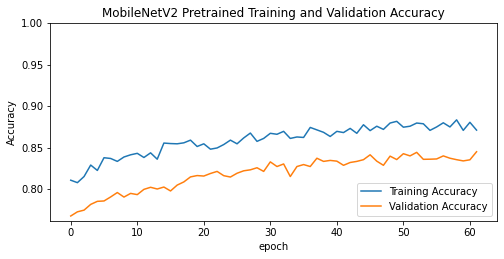

In [19]:
NUM_EPOCHS = 100

mobile_net_v2_fine_tune_history = mobile_net_v2_fine_tune_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint, earlystop, reduce_lr],
)
show_history(mobile_net_v2_fine_tune_history, 'MobileNetV2 Pretrained')

## Show result

In [20]:
print_accuracy(mobile_net_v2_fine_tune_model, test_generator, 'MobileNetV2 Pretrained')

2024-05-10 14:01:02.714165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6/6 [==============================] - 5s 750ms/step - loss: 0.4887 - accuracy: 0.8500
MobileNetV2 Pretrained accuracy: 0.8500000238418579


1/1 [==============================] - 1s 698ms/step


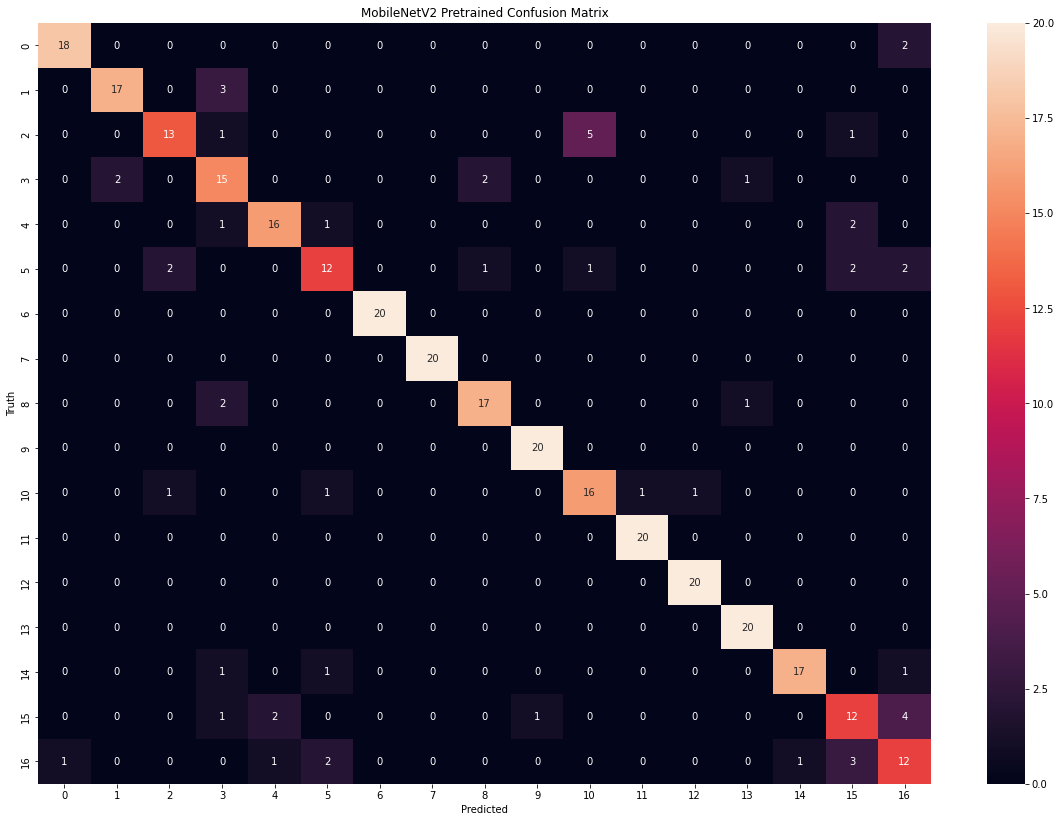

In [21]:
show_confusion_matrix(mobile_net_v2_fine_tune_model, test_generator, 'MobileNetV2 Pretrained')

In [25]:
import json

def dump_class_indices(generator, file_name='class_indices.json'):
    with open(file_name, 'w+') as f:
        json.dump(generator.class_indices, f)

    print(f'Class indices dumped to {file_name}')

dump_class_indices(train_generator)

train_generator.class_indices

Class indices dumped to class_indices.json


{'Ambulance': 0,
 'Barge': 1,
 'Bicycle': 2,
 'Boat': 3,
 'Bus': 4,
 'Car': 5,
 'Cart': 6,
 'Caterpillar': 7,
 'Helicopter': 8,
 'Limousine': 9,
 'Motorcycle': 10,
 'Segway': 11,
 'Snowmobile': 12,
 'Tank': 13,
 'Taxi': 14,
 'Truck': 15,
 'Van': 16}